In [5]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import LatticeDefinitions as ld
import GeometryFunctions as gf
import GeneralLattice as gl
import LAMMPSDump as LD
import scipy as sc
from skimage.morphology import skeletonize, thin, medial_axis
import os
from skimage.measure import label, regionprops
from IPython.core.debugger import set_trace

In [6]:
def CylinderVolume(h, R)->float:
    return np.pi*h*R**2
def PowerRule(r, a,b):
    return a*r**2+b*r
def LinearRule(r,m,c):
    return r*m+c 
def Quadratic(r,a,b,c):
    return a*r**2+b*r+c
def TQuadratic(r,b,c):
    return A*r**2+b*r+c
def DiffPowerRule(r,a,b):
    return b*a*r**(a-1)
def AsymptoticLinear(r,a,b):
    return a*r - b*np.log(r+b/a) + b*np.log(b/a)
def DiffAL(r,a,b):
    return a -b/(r+b/a)

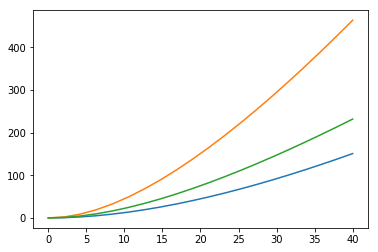

In [7]:
x = np.linspace(0,40,20)
plt.plot(x,AsymptoticLinear(x,15,812))
plt.plot(x,AsymptoticLinear(x,30,812))
plt.plot(x,AsymptoticLinear(x,15,406))
plt.show()

[ 1.23761833 -0.90932695] [-8.96249997  3.93001465 -0.33698183] [2.94126723 5.66970285] -3.359661391481419 -8.934599009814377 -0.00204517261633025


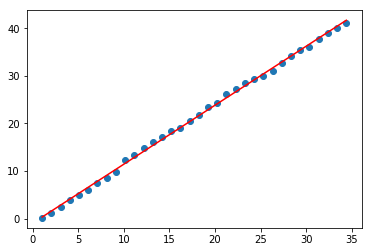

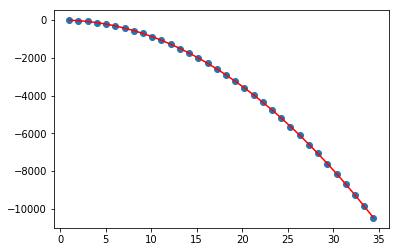

In [8]:
strDumpFile = '../data/dump.eam'
strPMFile = strDumpFile + 'PM'
objData = LD.LAMMPSData(strPMFile,1)
objProcess = objData.GetTimeStepByIndex(0)
objProcess.CategoriseAtoms()
a1=4.05
h= 2*a1*np.sqrt(3)
arrTriplePoints = objProcess.FindTriplePoints(a1)
#print(objProcess.GetCellVectors())
PEVolume= -3.36*5/(a1**3)
lstPE = []
lstValues = []
lstExcess =[]
lstFitLinear = []
lstFitQuadratic = []
lstTotalPE = []
lstFitTQuadratic = []
intCol = 0
intPE = objProcess.GetColumnNames().index('c_pe1')
intVS = objProcess.GetColumnNames().index('VolumetricStrain')
fltVolume = np.mean(objProcess.GetLatticeAtoms()[:,intVS])
fltMeanLatticePE = np.mean(objProcess.GetLatticeAtoms()[:,intPE])
A =fltMeanLatticePE*4*4.05**(-3)*h*np.pi/(1+fltVolume)
arrDistance = sc.spatial.distance_matrix(arrTriplePoints,arrTriplePoints)
fltClosest = np.sort(arrDistance[intCol])[1]
fltIncrement = 4.05/4
for j in range(1,np.floor(fltClosest/(2*fltIncrement)).astype('int')):
    r = fltIncrement*j
    lstValues.append(r)
    values = objProcess.FindValuesInCylinder(arrTriplePoints[intCol], r,7)
    lstTotalPE.append(np.sum(values))
    lstExcess.append(np.sum(values) -fltMeanLatticePE*len(values))
popt, popv = sc.optimize.curve_fit(LinearRule,lstValues, lstExcess)
popt2, popv2 = sc.optimize.curve_fit(Quadratic, lstValues,lstTotalPE)
popt3, popv3 = sc.optimize.curve_fit(TQuadratic, lstValues,lstTotalPE)
for k in lstValues:
    lstFitLinear.append(LinearRule(k, *popt))
    lstFitQuadratic.append(Quadratic(k, *popt2))
    lstFitTQuadratic.append(TQuadratic(k,*popt3))
plt.scatter(lstValues, lstExcess)
plt.plot(lstValues, lstFitLinear, c='r')
print(popt,popt2,popt3, fltMeanLatticePE, A,fltVolume)
plt.show()
plt.scatter(lstValues, lstTotalPE)
plt.plot(lstValues, lstFitQuadratic, c='r')
#plt.plot(lstValues, lstFitTQuadratic, c='g')

In [9]:
objProcess.GetColumnNames()

['id',
 'x',
 'y',
 'z',
 'vx',
 'vy',
 'vz',
 'c_pe1',
 'StructureType',
 'VolumetricStrain']

In [10]:
arrEnergies = objProcess.EstimateTripleLineEnergy(-3.306,4.05, True, True)
print(arrEnergies)
for j in range(len(arrEnergies)):
    print(arrEnergies[j,1]/(arrEnergies[j,1] -arrEnergies[j,2]))

[[-0.00203933 -0.23437126  0.23233193]
 [-0.00205277 -0.29183721  0.28978445]
 [-0.00204232 -0.3744668   0.37242448]
 [-0.00205771 -0.29244173  0.29038402]
 [-0.00200936 -0.45278268  0.45077332]
 [-0.00200195 -0.33085461  0.32885266]
 [-0.00203124 -0.36983405  0.36780281]
 [-0.0020097  -0.30470128  0.30269158]
 [-0.0020118  -0.32500366  0.32299186]
 [-0.00198809 -0.34187404  0.33988595]
 [-0.00207604 -0.28207775  0.28000171]]
0.5021848279240937
0.5017646920602769
0.5013672150842856
0.5017652832871914
0.5011119156931468
0.5015173050157539
0.5013768544329119
0.5016543663872375
0.5015523273817591
0.5014580546455006
0.5018467467679139


In [11]:
arrEnergies2 = objProcess.EstimateTripleLineEnergy(-3.36,4.05,False,False)
print(arrEnergies2)
for j in range(len(arrEnergies2)):
    print(arrEnergies2[j,1]/(arrEnergies2[j,1]-arrEnergies2[j,2]))

[[ 42.09044966  44.209044    -2.11859434]
 [ 41.81962448  36.350896     5.46872848]
 [ 42.17997196  48.060292    -5.88032004]
 [ 42.23794012  53.736218   -11.49827788]
 [ 41.84978397  34.76338792   7.08639604]
 [ 39.41548066  44.27270441  -4.85722375]
 [ 40.63835662  25.093134    15.54522262]
 [ 38.69977735  42.980864    -4.28108665]
 [ 41.03041594  43.300686    -2.27027006]
 [ 39.51463101  40.94953599  -1.43490498]
 [ 43.4109817   47.45489     -4.0439083 ]]
0.9542693214184211
1.1770836997998966
0.890985292548011
0.8237393004849144
1.2560392428390892
0.901135134359578
2.6281280799715963
0.9094179018580892
0.9501816451787756
0.9661454781603839
0.9214756763692711


In [12]:
fltMeanPEInLattice = np.mean(objProcess.GetLatticeAtoms()[:,7])
print(np.sum(objProcess.GetAtomData()[:,7])-fltMeanPEInLattice*objProcess.GetNumberOfAtoms(), fltMeanPEInLattice)

252.02592069574166 -3.359661391481419


In [13]:
intN = len(arrTriplePoints)

In [14]:
def PotentialEnergyInVolume(arrTriplePoint: np.array, fltRadius:float, fltHeight :float)->float:
    arrTriplePoints = objProcess.PeriodicEquivalents(arrTriplePoint)
    lstPoints = []
    for j in arrTriplePoints:
        lstPoints.extend(np.where(np.linalg.norm(objProcess.GetAtomData()[:,1:3]-j[0:2],axis=1) 
                         <fltRadius)[0])
    lstPoints = list(np.unique(lstPoints))
    return (np.sum(objProcess.GetAtomData()[lstPoints][:,7])/CylinderVolume(fltHeight,fltRadius)) 

In [15]:
def PotentialEnergyPerAtom(arrTriplePoint: np.array, fltRadius:float, fltHeight :float)->float:
    arrTriplePoints = objProcess.PeriodicEquivalents(arrTriplePoint)
    lstPoints = []
    for j in arrTriplePoints:
        lstPoints.extend(np.where(np.linalg.norm(objProcess.GetAtomData()[:,1:3]-j[0:2],axis=1) 
                         <fltRadius)[0])
    lstPoints = list(np.unique(lstPoints))
    return (np.sum(objProcess.GetAtomData()[lstPoints][:,7])/len(lstPoints)) 

In [16]:
def FormPotentialListVolume(intLength: int, flta: float, flth: float, arrPoint: np.array)->list:
    Radii = np.linspace(flta/(np.sqrt(2)),0.5*intLength*flta/(np.sqrt(2)),intLength)
    lstPotentialValues = []
    for r in Radii:
        lstPotentialValues.append(PotentialEnergyInVolume(arrPoint, r,flth))
    return Radii,lstPotentialValues

In [17]:
def FormPotentialListAtom(intLength: int, flta: float, flth: float, arrPoint: np.array)->list:
    Radii = np.linspace(flta/(np.sqrt(2)),0.5*intLength*flta/(np.sqrt(2)),intLength)
    lstPotentialValues = []
    for r in Radii:
        lstPotentialValues.append(PotentialEnergyPerAtom(arrPoint, r,flth))
    return Radii,lstPotentialValues

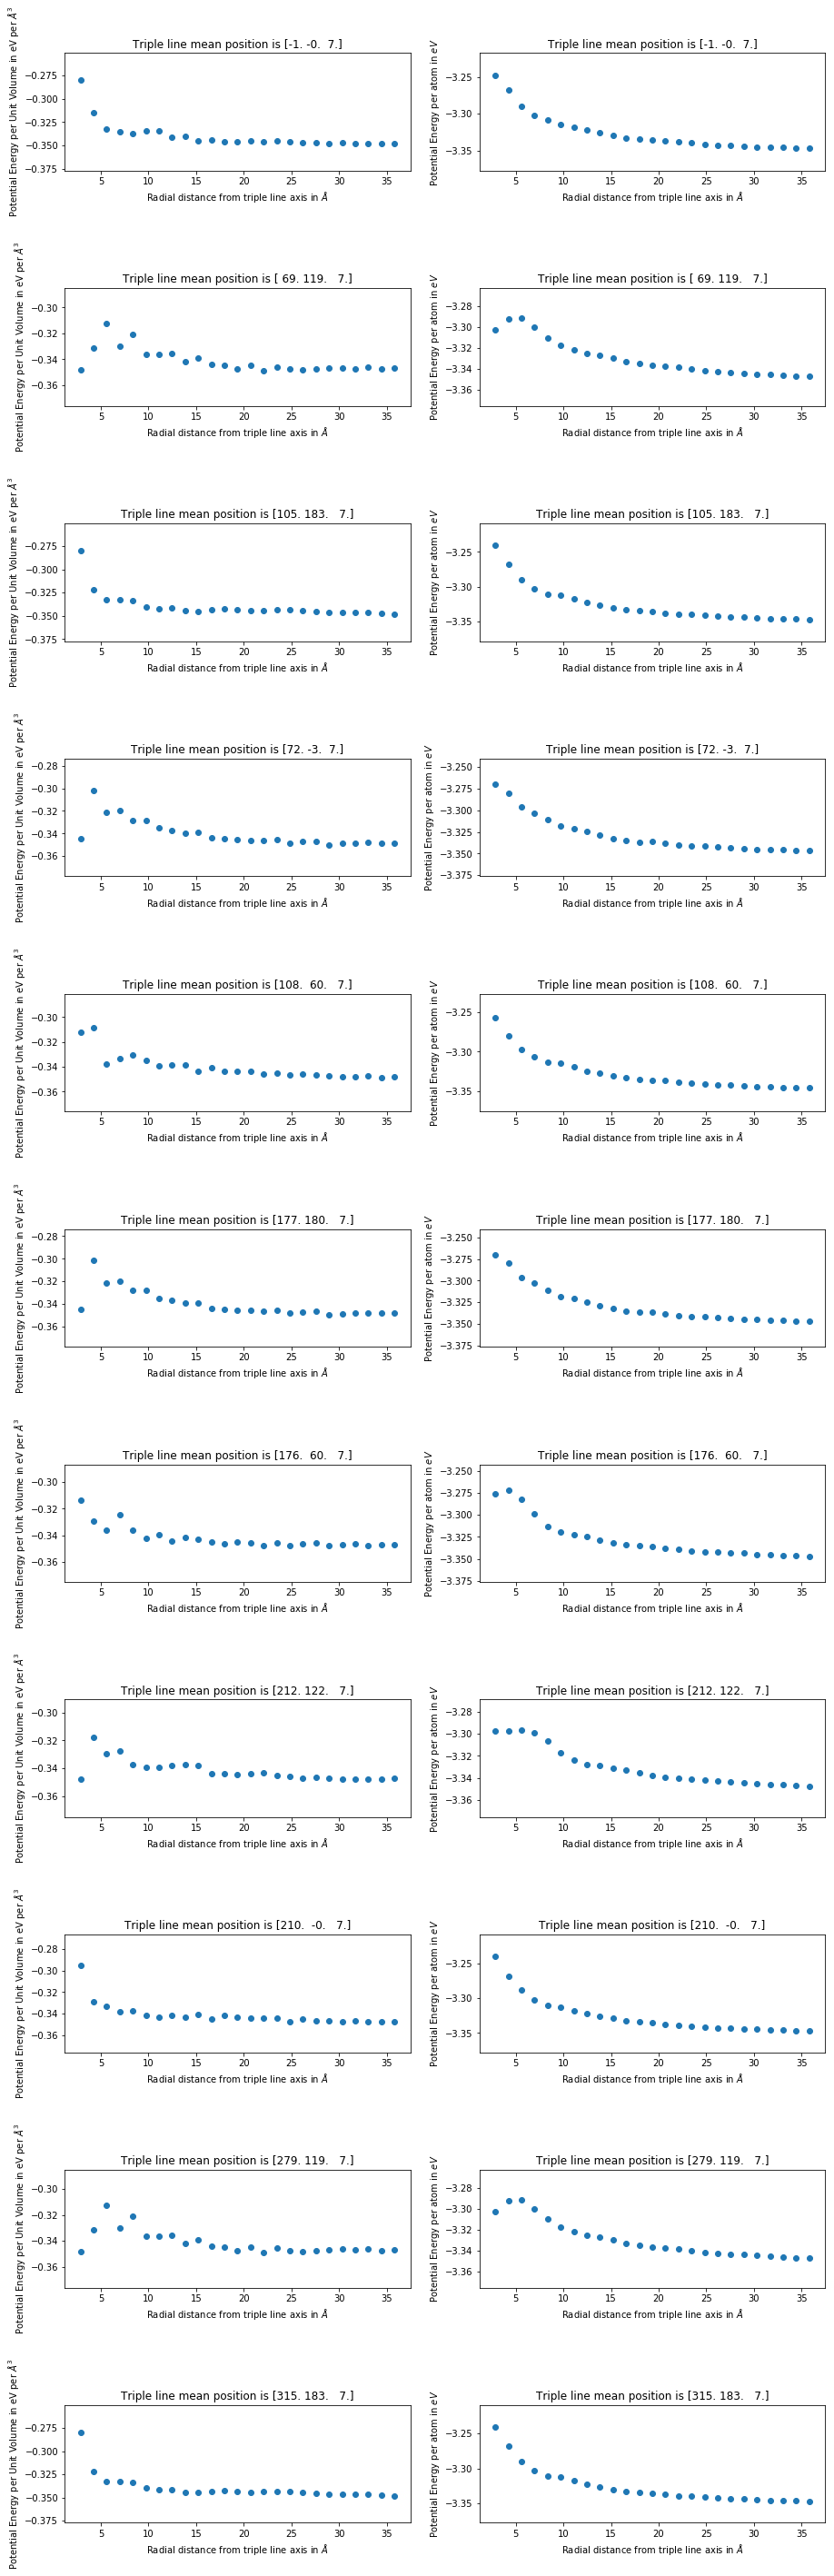

In [18]:
fig,axs = plt.subplots(len(arrTriplePoints),2, figsize = (15,50))
fig.subplots_adjust(hspace =1)
axs= axs.ravel()
for pos,j in enumerate(arrTriplePoints):
    axs[2*pos].scatter(*FormPotentialListVolume(25, a1, 2*a1, j))
    axs[2*pos+1].scatter(*FormPotentialListAtom(25, a1, 2*a1, j))
    axs[2*pos].set_title('Triple line mean position is '+ str(np.round(j)))
    axs[2*pos+1].set_title('Triple line mean position is '+ str(np.round(j)))
    axs[2*pos].set_ylabel('Potential Energy per Unit Volume in eV per $\AA^3$' )
    axs[2*pos].set_xlabel('Radial distance from triple line axis in $\AA$')
    axs[2*pos+1].set_ylabel('Potential Energy per atom in $eV$' )
    axs[2*pos+1].set_xlabel('Radial distance from triple line axis in $\AA$')

In [19]:
-3.36*4/(4.05**3) #FCC cell has 4 atoms in a perfect lattice each atom is approx -3.36 eV 

-0.20231784901804717

In [20]:
arrTriplePoints = objProcess.FindTriplePoints(4.05, True)
arrGrainBoundaries = objProcess.GetGrainBoundaries()
print(arrTriplePoints)

[[-7.25504340e-01 -2.83554000e-01  6.67388167e+00]
 [ 6.85017961e+01  1.18984200e+02  7.10721200e+00]
 [ 1.04664116e+02  1.82602003e+02  6.98225400e+00]
 [ 7.16815134e+01 -2.73180000e+00  6.56659200e+00]
 [ 1.07652000e+02  5.97495600e+01  7.04169400e+00]
 [ 1.76903600e+02  1.79518200e+02  6.56659200e+00]
 [ 1.76016857e+02  6.02300429e+01  7.34637429e+00]
 [ 2.12455833e+02  1.22317667e+02  7.03037000e+00]
 [ 2.09973220e+02 -2.43064800e-01  6.99004800e+00]
 [ 2.78945969e+02  1.18984200e+02  7.10721200e+00]
 [ 3.15108289e+02  1.82602003e+02  6.98225400e+00]]


In [21]:
def GetGrainBoundarySegments(objGB, fltWidth: float):
    #arrPoints = gf.SortInDistanceOrder(arr2DPoints[:,0:2])[0]
    lstPositions =[]
    lstTotalPE = []
    lstTotalPositions = []
    for j in range(0,objGB.GetNumberOfPoints()-1):
        arrVector = objGB.GetVector(j)
        arrAcross = fltWidth*objGB.GetAcrossVector(j)
        arrCentre3d = objGB.GetCentre(j) 
        arrCentre3d[2] = 4.05
        lstPositions = objProcess.FindBoxAtoms(arrCentre3d[0:2],arrVector[0:2],arrAcross[0:2])
      #  lstPositions = objProcess.FindCylindricalAtoms(np.array([arrPoints[j][0],arrPoints[j][1],0]), fltWidth)
        lstPositions = list(np.unique(lstPositions))
        lstTotalPE.append(np.sum(objProcess.GetRows(lstPositions)[:,intPE]))
        lstTotalPositions.extend(objProcess.GetRows(lstPositions)[:,1:3])
    lstTotalPositions = np.array(lstTotalPositions)
    return lstTotalPE, lstTotalPositions

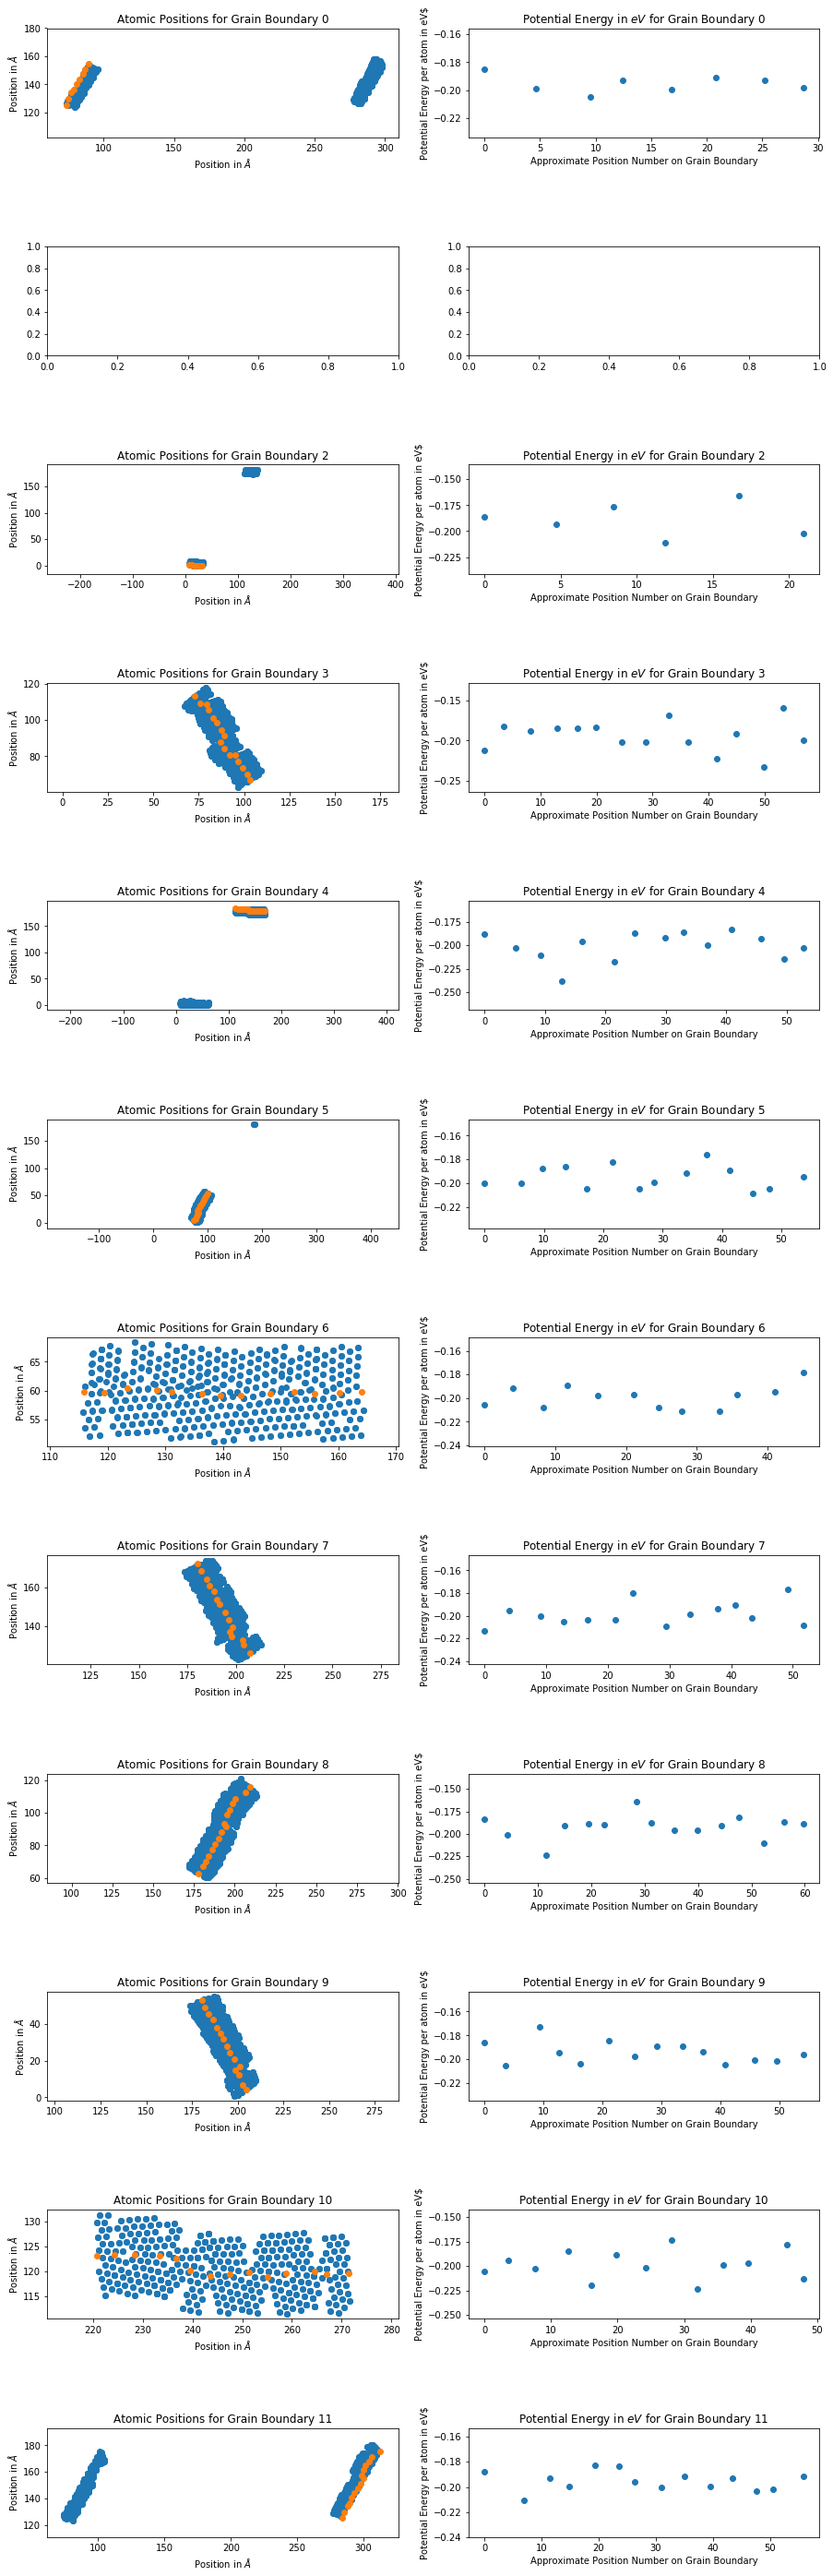

In [22]:
arrGrainBoundaries = objProcess.GetGrainBoundaries()
fig,axs = plt.subplots(len(arrGrainBoundaries),2, figsize = (15,50))
fig.subplots_adjust(hspace =1)
axs= axs.ravel()
lstPE = []
lstPositions = []
fltWidth= 4*a1
for j in range(len(arrGrainBoundaries)):
    if len(arrGrainBoundaries[j]) > 2: 
        lstLengths = []
        objGB = gl.GrainBoundary(arrGrainBoundaries[j])
        
        lstPE, lstPositions = GetGrainBoundarySegments(objGB, fltWidth)
        for k in range(len(lstPE)):
            lstLengths.append(objGB.GetAccumulativeLength(k))
            lstPE[k] = lstPE[k]/(objGB.GetSegmentLength(k)*fltWidth*h)
        axs[2*j].set(xlim=(0, objProcess.GetCellVectors()[0][0]+objProcess.GetCellVectors()[1][0]),
                     ylim = (0,objProcess.GetCellVectors()[1][1]))
        axs[2*j].axis('equal')
        axs[2*j].scatter(lstPositions[:,0],lstPositions[:,1])
        axs[2*j].scatter(objGB.GetPoints()[:,0],objGB.GetPoints()[:,1])
        axs[2*j+1].scatter(lstLengths,lstPE)
        axs[2*j].set_title('Atomic Positions for Grain Boundary '+ str(np.round(j)))
        axs[2*j+1].set_title('Potential Energy in $eV$ for Grain Boundary '+ str(np.round(j)))
        axs[2*j].set_ylabel('Position in $\AA$' )
        axs[2*j].set_xlabel('Position in $\AA$')
        axs[2*j+1].set_ylabel('Potential Energy per atom in eV$' )
        axs[2*j+1].set_xlabel('Approximate Position Number on Grain Boundary')

In [23]:
print(len(lstLengths),len(lstPE))

14 14


In [24]:
objGB = gl.GrainBoundary(arrGrainBoundaries[1])
objGB.GetCentre(2)

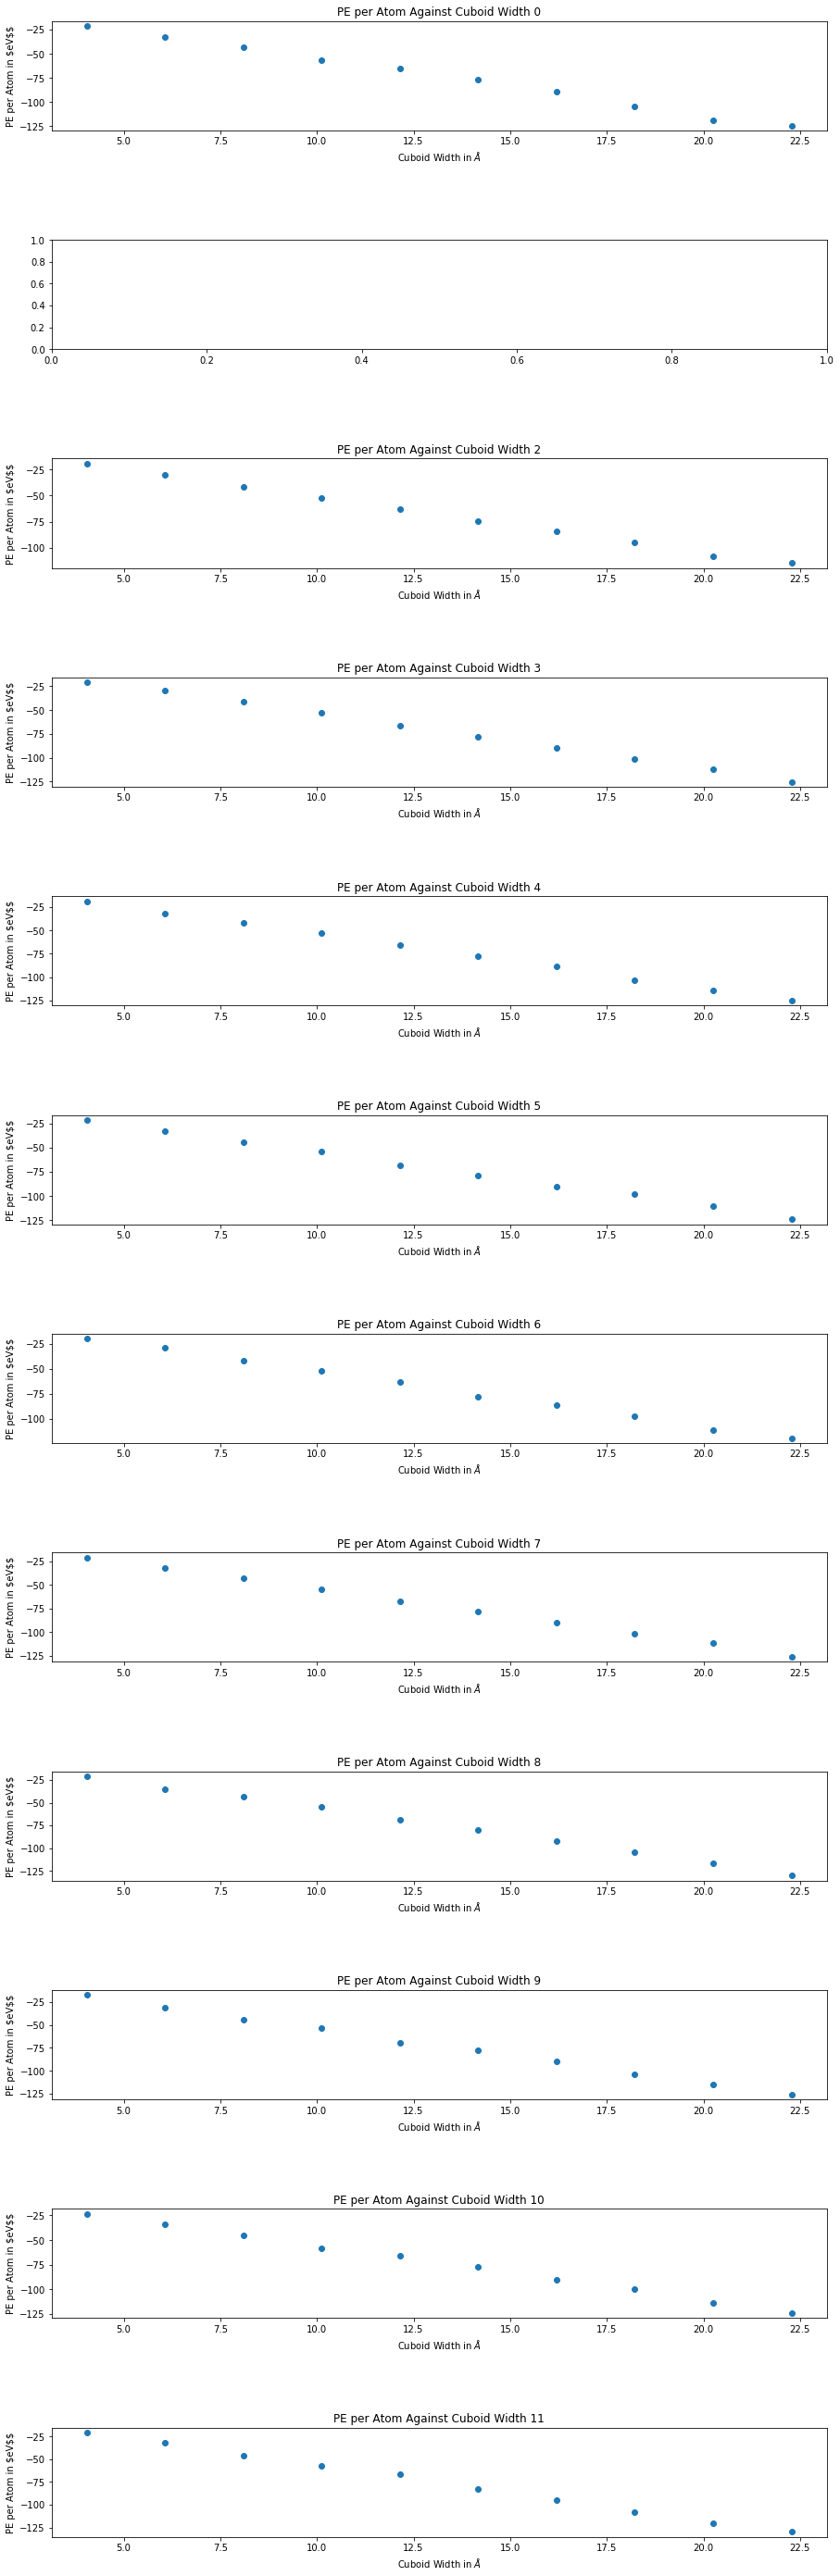

In [25]:
fig,axs = plt.subplots(len(arrGrainBoundaries),1, figsize = (15,50))
fig.subplots_adjust(hspace =1)
axs= axs.ravel()
for j in range(len(arrGrainBoundaries)):
    if len(arrGrainBoundaries[j]) > 1:
        objGB2 = gl.GrainBoundary(arrGrainBoundaries[j])
        lstPE = []
        lstWidth =[]
        for k in range(2,12):
            lstPE.append(np.mean(GetGrainBoundarySegments(objGB2, k*a1/4)[0]))
            lstWidth.append(k*a1/2) 
            
        axs[j].scatter(lstWidth,lstPE)
        axs[j].set_title('PE per Atom Against Cuboid Width '+ str(np.round(j)))
        axs[j].set_ylabel('PE per Atom in $eV$$' )
        axs[j].set_xlabel('Cuboid Width in $\AA$')
            

In [26]:
def TurningRegion(arrPoints, arrAcross1,arrAcross2, fltWidth)->list:
    lstIndices = []
    arrUnit1 = gf.NormaliseVector(arrAcross1[0:2])
    arrUnit2 = gf.NormaliseVector(arrAcross2[0:2])
    fltDirection = np.sign(np.cross(arrAcross1, arrAcross2)[2])
    if fltDirection < 0: 
        lstIndices.extend(np.where((np.dot(arrPoints,arrUnit1) > 0) & (np.dot(arrPoints,arrUnit1) < fltWidth)
                             & (np.dot(arrPoints,arrUnit2) > 0) & (np.dot(arrPoints,arrUnit2) < fltWidth))[0])
    elif fltDirection > 0:
        lstIndices.extend(np.where((np.dot(arrPoints,arrUnit1) < 0) & (np.dot(arrPoints,arrUnit1) > -fltWidth)
                                  & (np.dot(arrPoints,arrUnit2) < 0) & (np.dot(arrPoints,arrUnit2) > -fltWidth))[0])
    return list(lstIndices)

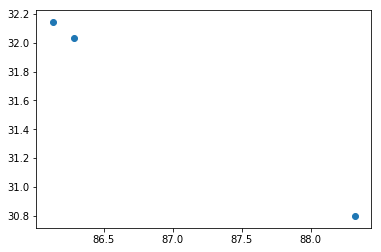

In [27]:
objGB1 = gl.GrainBoundary(arrGrainBoundaries[5])
lstPoints = TurningRegion(objProcess.GetAtomData()[:,1:3]-objGB1.GetPoints(6)[0:2], objGB1.GetVector(0), 
              objGB1.GetVector(8), 1)
plt.scatter(objProcess.GetRows(lstPoints)[:,1],objProcess.GetRows(lstPoints)[:,2]);

In [28]:
np.where(np.dot(objProcess.GetAtomData()[:,1:3]-objGB1.GetPoints(1)[0:2],
                gf.NormaliseVector(objGB1.GetVector(1))[0:2])<0)

(array([   99,   160,   161, ..., 32409, 32410, 32411]),)

In [29]:
lstPoints = gf.ArcSegment(objProcess.GetAtomData()[:,1:3], objGB1.GetVector(0), objGB1.GetVector(8), 125)
arrPoints = objProcess.GetRows(lstPoints)[:,1:3]
plt.scatter(*zip(*arrPoints))

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [ ]:
def GetGrainBoundary(objGB, fltWidth: float):
    #arrPoints = gf.SortInDistanceOrder(arr2DPoints[:,0:2])[0]
    lstPositions =[]
    lstTotalPE = []
    lstTotalPositions = []
    lstArcs = []
    arrFirstCentre = objGB.GetCentre(0)
    lstArcs.extend(gf.ArcSegment(objProcess.GetAtomData()[:,1:3]-arrFirstCentre[0:2],
                           objGB.GetAcrossVector(0)[0:2], -objGB.GetAcrossVector(0)[0:2], fltWidth))
    lstArcs.extend(gf.ArcSegment(objProcess.GetAtomData()[:,1:3]-arrFirstCentre[0:2],
                           objGB.GetAcrossVector(-1)[0:2], -objGB.GetAcrossVector(-1)[0:2], fltWidth))
    for j in range(0,objGB.GetNumberOfPoints()-1):
        arrVector = objGB.GetVector(j)
        arrAcross = fltWidth*objGB.GetAcrossVector(j)
        arrCentre3d = objGB.GetCentre(j) 
        arrCentre3d[2] = 4.05
        lstPositions.extend(objProcess.FindBoxAtoms(arrCentre3d[0:2],arrVector[0:2],arrAcross[0:2]))
        if j > 1:
            lstPositions.extend(gf.ArcSegment(objProcess.GetAtomData()[:,1:3]-arrCentre3d[0:2],
                           objGB.GetAcrossVector(j)[0:2], objGB.GetAcrossVector(j-1)[0:2], fltWidth))
            lstPositions.extend(gf.ArcSegment(objProcess.GetAtomData()[:,1:3]-arrCentre3d[0:2],
                           -objGB.GetAcrossVector(j)[0:2], -objGB.GetAcrossVector(j-1)[0:2], fltWidth))
      #  lstPositions = objProcess.FindCylindricalAtoms(np.array([arrPoints[j][0],arrPoints[j][1],0]), fltWidth)
        lstPositions = set(np.unique(lstPositions))
        lstPositions.difference(lstArcs)
        lstPositions = list(lstPositions)
        lstTotalPE.append(np.sum(objProcess.GetRows(lstPositions)[:,intPE]))
        lstTotalPositions.extend(objProcess.GetRows(lstPositions)[:,1:3])
    lstTotalPositions = np.array(lstTotalPositions)
    return lstTotalPE, lstTotalPositions

In [ ]:
GetGrainBoundary(objGB2,5)

In [ ]:
objGB2.GetAcrossVector(1)

In [ ]:
arrGrainBoundaries = objProcess.GetGrainBoundaries()
fig,axs = plt.subplots(len(arrGrainBoundaries),2, figsize = (15,50))
fig.subplots_adjust(hspace =1)
axs= axs.ravel()
lstPE = []
lstPositions = []
fltWidth= 2*a1
for j in range(len(arrGrainBoundaries)):
    if len(arrGrainBoundaries[j]) > 2: 
        lstLengths = []
        objGB = gl.GrainBoundary(arrGrainBoundaries[j])
        
        lstPE, lstPositions = GetGrainBoundary(objGB, fltWidth)
        for k in range(len(lstPE)):
            lstLengths.append(objGB.GetAccumulativeLength(k))
            lstPE[k] = lstPE[k]/(objGB.GetSegmentLength(k)*fltWidth*h)
        axs[2*j].set(xlim=(0, objProcess.GetCellVectors()[0][0]+objProcess.GetCellVectors()[1][0]),
                     ylim = (0,objProcess.GetCellVectors()[1][1]))
        axs[2*j].axis('equal')
        axs[2*j].scatter(lstPositions[:,0],lstPositions[:,1])
        axs[2*j].scatter(objGB.GetPoints()[:,0],objGB.GetPoints()[:,1])
        axs[2*j+1].scatter(lstLengths,lstPE)
        axs[2*j].set_title('Atomic Positions for Grain Boundary '+ str(np.round(j)))
        axs[2*j+1].set_title('Potential Energy in $eV$ for Grain Boundary '+ str(np.round(j)))
        axs[2*j].set_ylabel('Position in $\AA$' )
        axs[2*j].set_xlabel('Position in $\AA$')
        axs[2*j+1].set_ylabel('Potential Energy per atom in eV$' )
        axs[2*j+1].set_xlabel('Approximate Position Number on Grain Boundary')